In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")

#Import standard pydata libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
filename = 'facies.csv'
training_data = pd.read_csv(filename)
#training_data['Well Name'] = training_data['Well Name'].astype('category')
#training_data['Formation'] = training_data['Formation'].astype('category')
training_data['train'] = 1
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,train
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000,4149.0
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852,1.0
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644,0.0
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,1.0
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000,1.0
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000,1.0
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000,1.0
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,1.0


In [ ]:
validation_data = pd.read_csv("validation_data_nofacies.csv")
#validation_data['Well Name'] = validation_data['Well Name'].astype('category')
#validation_data['Formation'] = validation_data['Formation'].astype('category')
validation_data['train'] = 0
validation_data.describe()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,train
count,830.000000,830.00000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.0
mean,2987.070482,57.61173,0.666312,2.851964,11.655277,3.654178,1.678313,0.535807,0.0
std,94.391925,27.52774,0.288367,3.442074,5.190236,0.649793,0.467405,0.283062,0.0
min,2808.000000,12.03600,-0.468000,-8.900000,1.855000,2.113000,1.000000,0.013000,0.0
25%,2911.625000,36.77325,0.541000,0.411250,7.700000,3.171500,1.000000,0.300000,0.0
50%,2993.750000,58.34450,0.675000,2.397500,10.950000,3.515500,2.000000,0.547500,0.0
75%,3055.375000,73.05150,0.850750,4.600000,14.793750,4.191500,2.000000,0.778000,0.0
max,3160.500000,220.41300,1.507000,16.500000,31.335000,6.321000,2.000000,1.000000,0.0


In [ ]:
all_data = training_data.append(validation_data)
all_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,train
count,4149.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4062.000000,4979.000000,4979.000000,4979.000000
mean,4.503254,2920.237297,63.713364,0.660690,4.144012,12.943383,3.710540,1.545089,0.524178,0.833300
std,2.474324,131.086857,29.979746,0.258971,5.049037,6.871145,0.852033,0.498013,0.286069,0.372745
min,1.000000,2573.500000,10.149000,-0.468000,-21.832000,0.550000,0.200000,1.000000,0.000000,0.000000
25%,2.000000,2837.750000,43.197000,0.503623,1.330000,8.350000,3.130000,1.000000,0.281000,1.000000
50%,4.000000,2943.000000,64.085000,0.645226,3.900000,11.800000,3.537000,2.000000,0.530000,1.000000
75%,6.000000,3016.000000,78.555000,0.829000,7.000000,15.826000,4.298250,2.000000,0.771500,1.000000
max,9.000000,3160.500000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,1.000000


In [ ]:
dfs = []
for well in all_data['Well Name'].unique():
    df = all_data[all_data['Well Name']==well].copy(deep=True)
    df.sort_values('Depth', inplace=True)
    for col in ['PE', 'GR']:
        smooth_col = 'smooth_'+col
        df[smooth_col] = df[col].rolling(10).mean()
        df[smooth_col].fillna(method='ffill', inplace=True)
        df[smooth_col].fillna(method='bfill', inplace=True)
    dfs.append(df)
all_data = pd.concat(dfs)
pe_mean = all_data.PE.mean()
sm_pe_mean = all_data.smooth_PE.mean()
all_data['PE'] = all_data.PE.replace({np.nan:pe_mean})
all_data['smooth_PE'] = all_data['smooth_PE'].replace({np.nan:sm_pe_mean})
formation_encoder = dict(zip(all_data.Formation.unique(), range(len(all_data.Formation.unique()))))
all_data['enc_formation'] = all_data.Formation.map(formation_encoder)

In [ ]:
all_data.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'train', 'smooth_PE',
       'smooth_GR', 'enc_formation'],
      dtype='object')

In [ ]:
from sklearn import preprocessing

feature_names = all_data.drop(['Well Name', 'train', 'Depth', 'Formation', 'enc_formation', 'Facies'], axis=1).columns
train_labels = all_data.train.tolist()
facies_labels = all_data.Facies.tolist()
well_names = all_data['Well Name'].tolist()
depths = all_data.Depth.tolist()

scaler = preprocessing.StandardScaler().fit(all_data.drop(['Well Name', 'train', 'Depth', 'Formation', 'enc_formation', 'Facies'], axis=1))
scaled_features = scaler.transform(all_data.drop(['Well Name', 'train', 'Depth', 'Formation', 'enc_formation', 'Facies'], axis=1))

scaled_df = pd.DataFrame(scaled_features, columns=feature_names)
scaled_df['train'] = train_labels
scaled_df['Facies'] = facies_labels
scaled_df['Well Name'] = well_names
scaled_df['Depth'] = depths

In [ ]:
def to_binary_vec(value, vec_length):
    vec = np.zeros(vec_length+1)
    vec[value] = 1
    return vec

catagorical_vars = []

for i in all_data.enc_formation:
    vec = to_binary_vec(i, all_data.enc_formation.max())
    catagorical_vars.append(vec)
    
catagorical_vars = np.array(catagorical_vars)

for i in range(catagorical_vars.shape[1]):
    scaled_df['f'+str(i)] = catagorical_vars[:,i]

In [ ]:
dfs = list()
for well in all_data['Well Name'].unique():
    tmp_df = all_data[all_data['Well Name'] == well].copy(deep=True)
    tmp_df.sort_values('Depth', inplace=True)
    for feature in ['PE', 'GR']:
        tmp_df['3'+feature] = tmp_df[feature] / tmp_df[feature].shift(1)
        
        tmp_df['3'+feature].fillna(0, inplace=True)
        
    dfs.append(tmp_df)
scaled_df = pd.concat(dfs)

In [ ]:
#Let's build a model
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from classification_utilities import display_cm
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split


In [ ]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy(cm):
    total_correct = 0.
    nb_classes = cm.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += cm[i][i]
    acc = total_correct/sum(sum(cm))
    return acc

def accuracy_adjacent(cm, adjacent_facies):
    nb_classes = cm.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += cm[i][i]
        for j in adjacent_facies[i]:
            total_correct += cm[i][j]
    return total_correct / sum(sum(cm))

In [ ]:
import xgboost as xgb
#We will take a look at an F1 score for each well
estimators=200
learning_rate=.01
random_state=0
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

title_length = 20 

training_data = scaled_df[scaled_df.train==1]
scores = list()

wells = training_data['Well Name'].unique()
for well in wells:
    blind = training_data[training_data['Well Name']==well]
    train = training_data[(training_data['Well Name']!=well)]
    
    train_X = train.drop(['Well Name', 'Facies', 'Depth', 'train', 'Formation'], axis=1)
    train_Y = train.Facies.values
    test_X = blind.drop(['Well Name', 'Facies', 'Depth', 'train', 'Formation'], axis=1)
    test_Y = blind.Facies.values
    
    gcf = xgb.XGBClassifier(n_estimators=2000, learning_rate=learning_rate)
    gcf.fit(train_X,train_Y)
    pred_Y = gcf.predict(test_X)
    f1 = metrics.f1_score(test_Y, pred_Y, average='micro')
    scores.append(f1)
    print("*"*title_length)
    print("{well}={f1:.4f}".format(well=well,f1=f1))
    print("*"*title_length)
print("Avg F1: {score}".format(score=sum(scores)/len(scores)))

********************
SHRIMPLIN=0.5945
********************
********************
ALEXANDER D=0.6330
********************
********************
SHANKLE=0.4989
********************
********************
LUKE G U=0.6009
********************
********************
KIMZEY A=0.5353
********************
********************
CROSS H CATTLE=0.4112
********************
********************
NOLAN=0.4892
********************
********************
Recruit F9=0.7500
********************
********************
NEWBY=0.4881
********************
********************
CHURCHMAN BIBLE=0.5594
********************
Avg F1: 0.5560449812880652


In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(training_data.drop(['Well Name', 'Facies', 'Depth', 'train', 'Formation'], axis=1), training_data.Facies.values, test_size=.2)


In [ ]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)


(3319, 12)
(3319,)
(830, 12)
(830,)


In [ ]:
gcf = xgb.XGBClassifier(n_estimators=2000, learning_rate=learning_rate)
gcf.fit(train_X,train_Y)
pred_Y = gcf.predict(test_X)
cm = metrics.confusion_matrix(y_true=test_Y, y_pred=pred_Y)
display_cm(cm, facies_labels, display_metrics=True)

     Pred
            SS
          CSiS
          FSiS
          SiSh
            MS
            WS
             D
            PS
            BS
         Total
     True
            SS
            31
            16
             2
              
              
              
              
              
              
            49
          CSiS
            12
           147
            27
              
              
              
              
             1
              
           187
          FSiS
              
            35
           121
             1
              
              
              
             4
              
           161
          SiSh
              
              
             1
            35
             2
             8
             1
             1
              
            48
            MS
              
             1
             1
             2
            23
            15
             2
             8
              
            52
     

In [ ]:
print ('Facies classification accuracy = %f' % accuracy(cm))
print ('Adjacent facies classification accuracy = %f' % accuracy_adjacent(cm, adjacent_facies))

Facies classification accuracy = 0.736145
Adjacent facies classification accuracy = 0.942169


Text(0.5, 1.0, 'Confusion Matrix')

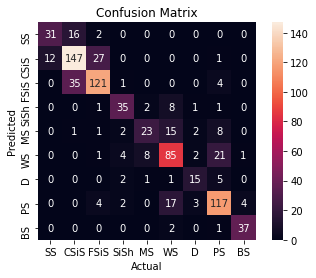

In [ ]:
axes = sns.heatmap(cm,annot=True, fmt="d",square=True, cbar=True, xticklabels= facies_labels, yticklabels= facies_labels)
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.set_title('Confusion Matrix')